In [1]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML
from diffusion_utilities import *

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
# MNIST
from torchvision import datasets, transforms
dataset = datasets.FashionMNIST('~/.pytorch/FashionMNIST_data/', train=True, download=True, transform=transform)

# Setting Things Up

In [4]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=28):  # cfeat - context features
        super(ContextUnet, self).__init__()

        # number of input channels, number of intermediate feature maps and number of classes
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height  #assume h == w. must be divisible by 4, so 28,24,20,16...

        # Initialize the initial convolutional layer
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        # Initialize the down-sampling path of the U-Net with two levels
        self.down1 = UnetDown(n_feat, n_feat)        # down1 #[10, 256, 8, 8]
        self.down2 = UnetDown(n_feat, 2 * n_feat)    # down2 #[10, 256, 4,  4]
        
         # original: self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())

        # Embed the timestep and context labels with a one-layer fully connected neural network
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)

        # Initialize the up-sampling path of the U-Net with three levels
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//4, self.h//4), # up-sample 
            nn.GroupNorm(8, 2 * n_feat), # normalize                        
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        # Initialize the final convolutional layers to map to the same number of channels as the input image
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1), # reduce number of feature maps   #in_channels, out_channels, kernel_size, stride=1, padding=0
            nn.GroupNorm(8, n_feat), # normalize
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1), # map to same number of channels as input
        )

    def forward(self, x, t, c=None):
        """
        x : (batch, n_feat, h, w) : input image
        t : (batch, n_cfeat)      : time step
        c : (batch, n_classes)    : context label
        """
        # x is the input image, c is the context label, t is the timestep, context_mask says which samples to block the context on

        # pass the input image through the initial convolutional layer
        x = self.init_conv(x)
        # pass the result through the down-sampling path
        down1 = self.down1(x)       #[10, 256, 8, 8]
        down2 = self.down2(down1)   #[10, 256, 4, 4]
        
        # convert the feature maps to a vector and apply an activation
        hiddenvec = self.to_vec(down2)
        
        # mask out context if context_mask == 1
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)
            
        # embed context and timestep
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)
        #print(f"uunet forward: cemb1 {cemb1.shape}. temb1 {temb1.shape}, cemb2 {cemb2.shape}. temb2 {temb2.shape}")


        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out


In [41]:
# hyperparameters

# diffusion hyperparameters
timesteps = 1000
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
device = torch.device("mps" if torch.backends.mps.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 10 # context vector is of size 10
height = 28 # 16x16 image
save_dir = './weights_1000_3v2/'
chan = 1

# training hyperparameters
batch_size = 64
n_epoch = 20
lrate=1e-3

In [42]:
# construct DDPM noise schedule
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()    
ab_t[0] = 1

In [43]:
# construct model
nn_model = ContextUnet(in_channels=chan, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

# Choose dataset

In [44]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [45]:
from torchvision import datasets, transforms
dataset = datasets.FashionMNIST('~/.pytorch/FashionMNIST_data/', train=True, download=True, transform=transform)
mask_1 = dataset.targets == 2
mask_2 = dataset.targets == 7
mask = mask_1 | mask_2
dataset = torch.utils.data.Subset(dataset, torch.where(mask)[0])


In [46]:
len(dataset)

12000

In [47]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# Visualize

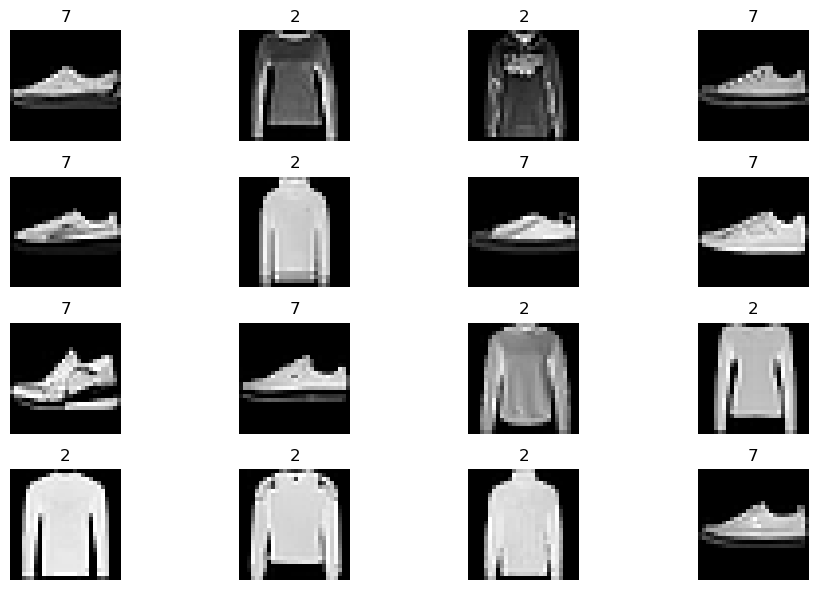

In [44]:
def show_images(images, labels, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(labels[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize a batch of images from the dataset
images, labels = next(iter(dataloader))  # Assuming trainloader is defined
show_images(images.numpy(), labels.numpy(), 4, 4)

# Training

In [48]:

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

In [49]:
# helper function: perturbs an image to a specified noise level 
def perturb_input(x, t, noise):
    return ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise

#### This code will take hours to run on a CPU. We recommend you skip this step here and check the intermediate results below.
If you decide to try it, you could download to your own machine. Be sure to change the cell type. 
Note, the CPU run time in the course is limited so you will not be able to fully train the network using the class platform.

In [50]:
n_epoch = 100

In [39]:
# load in model weights and set to eval mode
nn_model.load_state_dict(torch.load("weights_1000_3/Fashion_18_056.pth", map_location=device))

<All keys matched successfully>

In [51]:
# training without context code
l_min = 1
# set into train mode
nn_model.train()

for ep in range(n_epoch):
    print(f'epoch {ep}')
    
    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)
    
    pbar = tqdm(dataloader, mininterval=2 )
    for x, _ in pbar:   # x: images
        optim.zero_grad()
        x = x.to(device)
        
        # perturb data
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device) 
        x_pert = perturb_input(x, t, noise)
        
        # use network to recover noise
        pred_noise = nn_model(x_pert, t / timesteps)
        
        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        loss.backward()
        
        optim.step()
    print("Loss = ", loss.item())
    # save model periodically
    if ep%10==0 or ep == int(n_epoch-1) or l_min>loss.item():
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        if l_min>loss.item():
            l_min = loss.item()
        torch.save(nn_model.state_dict(), save_dir + f"Fashion_{ep}.pth")
        print('saved model at ' + save_dir + f"Fashion_{ep}.pth")
        

epoch 0


100%|██████████| 188/188 [01:16<00:00,  2.44it/s]


Loss =  0.30110058188438416
saved model at ./weights_1000_3v2/Fashion_0.pth
epoch 1


100%|██████████| 188/188 [01:12<00:00,  2.58it/s]


Loss =  0.22855181992053986
saved model at ./weights_1000_3v2/Fashion_1.pth
epoch 2


100%|██████████| 188/188 [01:10<00:00,  2.65it/s]


Loss =  0.13597385585308075
saved model at ./weights_1000_3v2/Fashion_2.pth
epoch 3


100%|██████████| 188/188 [01:10<00:00,  2.66it/s]


Loss =  0.12431876361370087
saved model at ./weights_1000_3v2/Fashion_3.pth
epoch 4


100%|██████████| 188/188 [01:10<00:00,  2.68it/s]


Loss =  0.0983307883143425
saved model at ./weights_1000_3v2/Fashion_4.pth
epoch 5


100%|██████████| 188/188 [01:19<00:00,  2.37it/s]


Loss =  0.17852428555488586
epoch 6


100%|██████████| 188/188 [01:16<00:00,  2.46it/s]


Loss =  0.09598563611507416
saved model at ./weights_1000_3v2/Fashion_6.pth
epoch 7


100%|██████████| 188/188 [01:09<00:00,  2.69it/s]


Loss =  0.10597129166126251
epoch 8


100%|██████████| 188/188 [01:09<00:00,  2.70it/s]


Loss =  0.06667932122945786
saved model at ./weights_1000_3v2/Fashion_8.pth
epoch 9


100%|██████████| 188/188 [00:57<00:00,  3.26it/s]


Loss =  0.08869177848100662
epoch 10


100%|██████████| 188/188 [00:39<00:00,  4.74it/s]


Loss =  0.10374278575181961
saved model at ./weights_1000_3v2/Fashion_10.pth
epoch 11


100%|██████████| 188/188 [00:39<00:00,  4.79it/s]


Loss =  0.060567114502191544
saved model at ./weights_1000_3v2/Fashion_11.pth
epoch 12


100%|██████████| 188/188 [00:39<00:00,  4.81it/s]


Loss =  0.056720979511737823
saved model at ./weights_1000_3v2/Fashion_12.pth
epoch 13


100%|██████████| 188/188 [00:38<00:00,  4.93it/s]


Loss =  0.11371392756700516
epoch 14


100%|██████████| 188/188 [00:39<00:00,  4.79it/s]


Loss =  0.07880333811044693
epoch 15


100%|██████████| 188/188 [00:37<00:00,  4.96it/s]


Loss =  0.13001418113708496
epoch 16


100%|██████████| 188/188 [00:37<00:00,  5.00it/s]


Loss =  0.09974607080221176
epoch 17


100%|██████████| 188/188 [00:37<00:00,  5.00it/s]


Loss =  0.10252919048070908
epoch 18


100%|██████████| 188/188 [00:37<00:00,  4.97it/s]


Loss =  0.07112496346235275
epoch 19


100%|██████████| 188/188 [00:37<00:00,  5.03it/s]


Loss =  0.06337124854326248
epoch 20


100%|██████████| 188/188 [00:37<00:00,  5.04it/s]


Loss =  0.0909901112318039
saved model at ./weights_1000_3v2/Fashion_20.pth
epoch 21


100%|██████████| 188/188 [00:38<00:00,  4.91it/s]


Loss =  0.02570444345474243
saved model at ./weights_1000_3v2/Fashion_21.pth
epoch 22


100%|██████████| 188/188 [00:37<00:00,  5.05it/s]


Loss =  0.082219697535038
epoch 23


100%|██████████| 188/188 [00:37<00:00,  5.04it/s]


Loss =  0.031648557633161545
epoch 24


100%|██████████| 188/188 [00:37<00:00,  5.05it/s]


Loss =  0.044967055320739746
epoch 25


100%|██████████| 188/188 [00:37<00:00,  4.99it/s]


Loss =  0.060130584985017776
epoch 26


100%|██████████| 188/188 [00:37<00:00,  5.00it/s]


Loss =  0.10901477932929993
epoch 27


100%|██████████| 188/188 [00:37<00:00,  5.04it/s]


Loss =  0.08188644796609879
epoch 28


100%|██████████| 188/188 [00:37<00:00,  5.08it/s]


Loss =  0.0645817443728447
epoch 29


100%|██████████| 188/188 [00:37<00:00,  5.07it/s]


Loss =  0.09775282442569733
epoch 30


100%|██████████| 188/188 [00:37<00:00,  5.05it/s]


Loss =  0.061302412301301956
saved model at ./weights_1000_3v2/Fashion_30.pth
epoch 31


100%|██████████| 188/188 [00:37<00:00,  5.04it/s]


Loss =  0.07410353422164917
epoch 32


100%|██████████| 188/188 [00:38<00:00,  4.87it/s]


Loss =  0.05902956798672676
epoch 33


100%|██████████| 188/188 [00:45<00:00,  4.12it/s]


Loss =  0.06674574315547943
epoch 34


100%|██████████| 188/188 [00:45<00:00,  4.11it/s]


Loss =  0.09331973642110825
epoch 35


100%|██████████| 188/188 [00:50<00:00,  3.70it/s]


Loss =  0.04343952238559723
epoch 36


100%|██████████| 188/188 [00:40<00:00,  4.70it/s]


Loss =  0.06105472519993782
epoch 37


100%|██████████| 188/188 [00:52<00:00,  3.61it/s]


Loss =  0.07291243970394135
epoch 38


100%|██████████| 188/188 [00:40<00:00,  4.68it/s]


Loss =  0.13046641647815704
epoch 39


100%|██████████| 188/188 [00:44<00:00,  4.27it/s]


Loss =  0.056139152497053146
epoch 40


100%|██████████| 188/188 [00:47<00:00,  3.97it/s]


Loss =  0.0804901048541069
saved model at ./weights_1000_3v2/Fashion_40.pth
epoch 41


100%|██████████| 188/188 [00:38<00:00,  4.91it/s]


Loss =  0.03816447779536247
epoch 42


100%|██████████| 188/188 [00:37<00:00,  4.99it/s]


Loss =  0.08662475645542145
epoch 43


100%|██████████| 188/188 [00:37<00:00,  4.98it/s]


Loss =  0.06205049529671669
epoch 44


100%|██████████| 188/188 [00:37<00:00,  4.97it/s]


Loss =  0.06801161915063858
epoch 45


100%|██████████| 188/188 [00:38<00:00,  4.93it/s]


Loss =  0.046329326927661896
epoch 46


100%|██████████| 188/188 [00:37<00:00,  4.95it/s]


Loss =  0.0888814702630043
epoch 47


100%|██████████| 188/188 [00:37<00:00,  4.99it/s]


Loss =  0.03493060544133186
epoch 48


100%|██████████| 188/188 [00:38<00:00,  4.90it/s]


Loss =  0.09467986971139908
epoch 49


100%|██████████| 188/188 [00:40<00:00,  4.59it/s]


Loss =  0.0560811348259449
epoch 50


100%|██████████| 188/188 [00:40<00:00,  4.60it/s]


Loss =  0.07709534466266632
saved model at ./weights_1000_3v2/Fashion_50.pth
epoch 51


100%|██████████| 188/188 [00:38<00:00,  4.91it/s]


Loss =  0.04768407344818115
epoch 52


100%|██████████| 188/188 [00:37<00:00,  4.98it/s]


Loss =  0.11921654641628265
epoch 53


100%|██████████| 188/188 [00:37<00:00,  5.06it/s]


Loss =  0.10812865942716599
epoch 54


100%|██████████| 188/188 [00:37<00:00,  5.03it/s]


Loss =  0.068792924284935
epoch 55


100%|██████████| 188/188 [00:37<00:00,  5.01it/s]


Loss =  0.05019316449761391
epoch 56


100%|██████████| 188/188 [00:38<00:00,  4.89it/s]


Loss =  0.02465439774096012
saved model at ./weights_1000_3v2/Fashion_56.pth
epoch 57


100%|██████████| 188/188 [00:51<00:00,  3.64it/s]


Loss =  0.08951874077320099
epoch 58


100%|██████████| 188/188 [00:39<00:00,  4.78it/s]


Loss =  0.06683272868394852
epoch 59


100%|██████████| 188/188 [00:37<00:00,  4.95it/s]


Loss =  0.0848531424999237
epoch 60


100%|██████████| 188/188 [00:38<00:00,  4.92it/s]


Loss =  0.09001798182725906
saved model at ./weights_1000_3v2/Fashion_60.pth
epoch 61


100%|██████████| 188/188 [00:38<00:00,  4.93it/s]


Loss =  0.0830279141664505
epoch 62


100%|██████████| 188/188 [00:37<00:00,  4.95it/s]


Loss =  0.1039990559220314
epoch 63


100%|██████████| 188/188 [00:37<00:00,  4.95it/s]


Loss =  0.06594711542129517
epoch 64


100%|██████████| 188/188 [00:38<00:00,  4.82it/s]


Loss =  0.04111156240105629
epoch 65


100%|██████████| 188/188 [00:38<00:00,  4.88it/s]


Loss =  0.038667887449264526
epoch 66


100%|██████████| 188/188 [00:37<00:00,  4.96it/s]


Loss =  0.061359141021966934
epoch 67


100%|██████████| 188/188 [00:38<00:00,  4.92it/s]


Loss =  0.0653761699795723
epoch 68


100%|██████████| 188/188 [00:38<00:00,  4.94it/s]


Loss =  0.027943281456828117
epoch 69


100%|██████████| 188/188 [00:38<00:00,  4.91it/s]


Loss =  0.04871346801519394
epoch 70


100%|██████████| 188/188 [00:38<00:00,  4.94it/s]


Loss =  0.04727243259549141
saved model at ./weights_1000_3v2/Fashion_70.pth
epoch 71


100%|██████████| 188/188 [00:51<00:00,  3.65it/s]


Loss =  0.019941607490181923
saved model at ./weights_1000_3v2/Fashion_71.pth
epoch 72


100%|██████████| 188/188 [00:39<00:00,  4.76it/s]


Loss =  0.07460177689790726
epoch 73


100%|██████████| 188/188 [00:51<00:00,  3.66it/s]


Loss =  0.09854978322982788
epoch 74


100%|██████████| 188/188 [00:40<00:00,  4.66it/s]


Loss =  0.09041605144739151
epoch 75


100%|██████████| 188/188 [00:38<00:00,  4.87it/s]


Loss =  0.09141458570957184
epoch 76


100%|██████████| 188/188 [00:37<00:00,  4.95it/s]


Loss =  0.09859709441661835
epoch 77


100%|██████████| 188/188 [00:38<00:00,  4.88it/s]


Loss =  0.08596755564212799
epoch 78


100%|██████████| 188/188 [00:38<00:00,  4.93it/s]


Loss =  0.06379207968711853
epoch 79


100%|██████████| 188/188 [00:38<00:00,  4.92it/s]


Loss =  0.10380363464355469
epoch 80


100%|██████████| 188/188 [00:38<00:00,  4.93it/s]


Loss =  0.024287542328238487
saved model at ./weights_1000_3v2/Fashion_80.pth
epoch 81


100%|██████████| 188/188 [00:52<00:00,  3.59it/s]


Loss =  0.0330069400370121
epoch 82


100%|██████████| 188/188 [00:41<00:00,  4.58it/s]


Loss =  0.06332672387361526
epoch 83


100%|██████████| 188/188 [00:38<00:00,  4.83it/s]


Loss =  0.04169901832938194
epoch 84


100%|██████████| 188/188 [00:38<00:00,  4.92it/s]


Loss =  0.05068206787109375
epoch 85


100%|██████████| 188/188 [00:38<00:00,  4.88it/s]


Loss =  0.06710201501846313
epoch 86


100%|██████████| 188/188 [00:46<00:00,  4.01it/s]


Loss =  0.08284967392683029
epoch 87


100%|██████████| 188/188 [00:43<00:00,  4.33it/s]


Loss =  0.06350269913673401
epoch 88


100%|██████████| 188/188 [00:39<00:00,  4.78it/s]


Loss =  0.08055852353572845
epoch 89


100%|██████████| 188/188 [00:38<00:00,  4.85it/s]


Loss =  0.04310857504606247
epoch 90


100%|██████████| 188/188 [00:50<00:00,  3.70it/s]


Loss =  0.0690411627292633
saved model at ./weights_1000_3v2/Fashion_90.pth
epoch 91


100%|██████████| 188/188 [00:39<00:00,  4.73it/s]


Loss =  0.06263171136379242
epoch 92


100%|██████████| 188/188 [00:49<00:00,  3.79it/s]


Loss =  0.07400064170360565
epoch 93


100%|██████████| 188/188 [00:41<00:00,  4.50it/s]


Loss =  0.08333528786897659
epoch 94


100%|██████████| 188/188 [00:39<00:00,  4.80it/s]


Loss =  0.08189014345407486
epoch 95


100%|██████████| 188/188 [00:38<00:00,  4.84it/s]


Loss =  0.08599185943603516
epoch 96


100%|██████████| 188/188 [00:39<00:00,  4.77it/s]


Loss =  0.06620778888463974
epoch 97


100%|██████████| 188/188 [00:38<00:00,  4.92it/s]


Loss =  0.0646272823214531
epoch 98


100%|██████████| 188/188 [00:38<00:00,  4.93it/s]


Loss =  0.04072820022702217
epoch 99


100%|██████████| 188/188 [00:39<00:00,  4.74it/s]

Loss =  0.06819821894168854
saved model at ./weights_1000_3v2/Fashion_99.pth
